# Построение модели для прогнозирования оттока клиентов
В течение данного проекта мы изучим данные о поведении клиентов "Бета-Банка" и построим модель, предсказывающую уход клиента на основании других данных о нем.
# Содержание
## [Загрузка данных](#step_1)
### [Выводы и замечания](#step_2)
## [Подготовка к обучению](#step_3)
### [Баланс классов](#step_3)
### [Прямое кодирование](#step_4)
## [Обучение без учета баланса классов](#step_5)
### [Разделение данных](#step_5)
### [Обучение моделей: решающее дерево, случайный лес и логистическая регрессия](#step_6)
### [Три лучшие модели](#step_7)
### [Обзор результатов](#step_8)
## [Обучение с учетом баланса классов](#step_9)
### [Увеличение размеров выборки: upsampling](#step_9)
### [Оценка полученных моделей](#step_10)
### [Результаты](#step_11)
## [Выводы](#step_12)

## Получение данных и изучение в первом приближении 
<a id='step_1'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import warnings

In [2]:
try:
    data = pd.read_csv(r'C:\Users\Семен\Downloads\Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')
data.columns = data.columns.str.lower()
data.drop(['rownumber', 'customerid', 'surname'], axis = 1, inplace = True)
data[['balance', 'estimatedsalary']] = data[['balance', 'estimatedsalary']].astype('int')
print(data.info())
display(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           9091 non-null   float64
 5   balance          10000 non-null  int32  
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  int32  
 10  exited           10000 non-null  int64  
dtypes: float64(1), int32(2), int64(6), object(2)
memory usage: 781.4+ KB
None


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0,1,1,1,101348,1
1,608,Spain,Female,41,1.0,83807,1,0,1,112542,0
2,502,France,Female,42,8.0,159660,3,1,0,113931,1
3,699,France,Female,39,1.0,0,2,0,0,93826,0
4,850,Spain,Female,43,2.0,125510,1,1,1,79084,0
5,645,Spain,Male,44,8.0,113755,2,1,0,149756,1
6,822,France,Male,50,7.0,0,2,1,1,10062,0
7,376,Germany,Female,29,4.0,115046,4,1,0,119346,1
8,501,France,Male,44,4.0,142051,2,0,1,74940,0
9,684,France,Male,27,2.0,134603,1,1,1,71725,0


### Выводы и замечания
<a id='step_2'></a>
- Для удобства понизили регистр всех колонок
- Колонки с уникальными значениями (`rownumber`, `customerid`) удалили - они не повторяются и не являются числовым признаком, а значит никак не помогут при обучении машины
- Также избавились от фамилий - они могут ухудшить качество предсказаний, если в данных есть случайные совпадения, которые алгоритм может посчитать за реальные зависимости
- Изменили формат данных: `tenure`, `estimatedsalary`, `balance` - в целые, так как `tenure` означает количество недвижимости, а копейки в зарплате и на балансе только "утяжеляют" данные
- Достаточно много значений пропущено в `tenure` - посмотрим на них поближе, заполним пропуски, а потом уже изменим формат данных этого параметра

In [3]:
display(data[data['tenure'].isna()].head(10))
print('Медианная зарплата для людей с неопределенным количеством недвижимости равна', data[data['tenure'].isna()]['estimatedsalary'].median())
print('Медианная зарплата для людей с определенным количеством недвижимости равна', data[data['tenure'].isna()==False]['estimatedsalary'].median())
print()
print('Медианная сумма на балансе для людей с неопределенным количеством недвижимости равна', data[data['tenure'].isna()]['balance'].median())
print('Медианная сумма на балансе для людей с определенным количеством недвижимости равна', data[data['tenure'].isna()==False]['balance'].median())
print()
print('Медианная зарплата для людей с неопределенным количеством недвижимости равна', data[data['tenure'].isna()]['geography'].unique())
print('Медианная зарплата для людей с определенным количеством недвижимости равна',data[data['tenure'].isna()==False]['geography'].unique())
print()
print('Возможные варианты `tenure`:', data['tenure'].unique())           

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,591,Spain,Female,39,NaN,0,3,1,0,140469,1
48,550,Germany,Male,38,NaN,103391,1,0,1,90878,0
51,585,Germany,Male,36,NaN,146050,2,0,0,86424,0
53,655,Germany,Male,41,NaN,125561,1,0,0,164040,1
60,742,Germany,Male,35,NaN,136857,1,0,0,84509,0
82,543,France,Female,36,NaN,0,2,0,0,26019,0
85,652,Spain,Female,75,NaN,0,2,1,1,114675,0
94,730,Spain,Male,42,NaN,0,2,0,1,85982,0
99,413,France,Male,34,NaN,0,2,0,0,6534,0
111,538,Germany,Male,39,NaN,108055,2,1,0,27231,0


Медианная зарплата для людей с неопределенным количеством недвижимости равна 99444.0
Медианная зарплата для людей с определенным количеством недвижимости равна 100240.0

Медианная сумма на балансе для людей с неопределенным количеством недвижимости равна 96674.0
Медианная сумма на балансе для людей с определенным количеством недвижимости равна 97318.0

Медианная зарплата для людей с неопределенным количеством недвижимости равна ['Spain' 'Germany' 'France']
Медианная зарплата для людей с определенным количеством недвижимости равна ['France' 'Spain' 'Germany']

Возможные варианты `tenure`: [ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]


- Посмотрели, зависит ли наличие значения в `tenure` от уровня заработной платы, суммы на балансе клиента и его местоположения. Оказалось - нет. Заполним пропуски медианным значением

In [4]:
tenure_median = data['tenure'].median()
data['tenure'].fillna(value = tenure_median, inplace = True)
print('Медианное значение `tenure` равно', tenure_median)
data['tenure'] = data['tenure'].astype('int')
data.info()
display(data.head(10))

Медианное значение `tenure` равно 5.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   creditscore      10000 non-null  int64 
 1   geography        10000 non-null  object
 2   gender           10000 non-null  object
 3   age              10000 non-null  int64 
 4   tenure           10000 non-null  int32 
 5   balance          10000 non-null  int32 
 6   numofproducts    10000 non-null  int64 
 7   hascrcard        10000 non-null  int64 
 8   isactivemember   10000 non-null  int64 
 9   estimatedsalary  10000 non-null  int32 
 10  exited           10000 non-null  int64 
dtypes: int32(3), int64(6), object(2)
memory usage: 742.3+ KB


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0,1,1,1,101348,1
1,608,Spain,Female,41,1,83807,1,0,1,112542,0
2,502,France,Female,42,8,159660,3,1,0,113931,1
3,699,France,Female,39,1,0,2,0,0,93826,0
4,850,Spain,Female,43,2,125510,1,1,1,79084,0
5,645,Spain,Male,44,8,113755,2,1,0,149756,1
6,822,France,Male,50,7,0,2,1,1,10062,0
7,376,Germany,Female,29,4,115046,4,1,0,119346,1
8,501,France,Male,44,4,142051,2,0,1,74940,0
9,684,France,Male,27,2,134603,1,1,1,71725,0


## Подготовка к машинному обучению
### Баланс классов
<a id='step_3'></a>

[Text(0, 0.5, 'Частота'),
 Text(0.5, 0, 'Класс'),
 Text(0.5, 1.0, 'Частоты классов')]

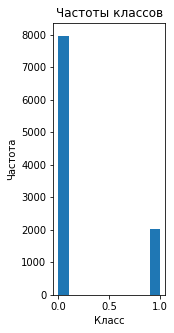

In [5]:
plt.figure()
data['exited'].plot(kind = 'hist', figsize = (2, 5)).set(xlabel = 'Класс', ylabel = 'Частота', title = 'Частоты классов')

Как видим, классы несбалансированы: большинство клиентов, данные о которых мы имеем, уже откакзались от услуг банка. Однако для точности пока что не будем делать на это попправку и обучим модель без поправки на несбалансирванность классов
### Прямое кодирование
<a id='step_4'></a>

In [6]:
data = pd.get_dummies(data)
display(data.head(10))

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,619,42,2,0,1,1,1,101348,1,1,0,0,1,0
1,608,41,1,83807,1,0,1,112542,0,0,0,1,1,0
2,502,42,8,159660,3,1,0,113931,1,1,0,0,1,0
3,699,39,1,0,2,0,0,93826,0,1,0,0,1,0
4,850,43,2,125510,1,1,1,79084,0,0,0,1,1,0
5,645,44,8,113755,2,1,0,149756,1,0,0,1,0,1
6,822,50,7,0,2,1,1,10062,0,1,0,0,0,1
7,376,29,4,115046,4,1,0,119346,1,0,1,0,1,0
8,501,44,4,142051,2,0,1,74940,0,1,0,0,0,1
9,684,27,2,134603,1,1,1,71725,0,1,0,0,0,1


В данном случае методом OHE обработаем поля `gender` и `geography` с удалением первого столбца, поскольку его можно однозначно восстановить по второму в случае с полом (к счастью или к сложалению, небинарные ребята в таблице отсутствуют) и по двум следующим, если говорить о стране, так как в данных только Германия, Франция и Испания.

## Обучение модели без учета баланса классов
### Разделим данные
<a id='step_5'></a>

In [7]:
df_train, df_test_valid = train_test_split(data, test_size = 0.4, random_state = 12345)
df_test, df_valid = train_test_split(df_test_valid, test_size = 0.5, random_state = 12345)
print('Размер обучающей выборки', df_train.shape)
print('Размер валидационной выборки', df_valid.shape)
print('Размер тестовой выборки', df_test.shape)

features_train = df_train.drop('exited', axis = 1).copy()
target_train = df_train['exited'].copy()

features_test = df_test.drop('exited', axis = 1).copy()
target_test = df_test['exited'].copy()

features_valid = df_valid.drop('exited', axis = 1).copy()
target_valid = df_valid['exited'].copy()


Размер обучающей выборки (6000, 14)
Размер валидационной выборки (2000, 14)
Размер тестовой выборки (2000, 14)


### Непосредственное обучение моделей
<a id='step_6'></a>

In [8]:
best_f1_tree = 0
for depth in range(1, 50):
    tree = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    tree.fit(features_train, target_train)
    predictions_train = tree.predict(features_train)
    predictions_valid = tree.predict(features_valid)
    if f1_score(target_valid, predictions_valid) > best_f1_tree:
        best_f1_tree = f1_score(target_valid, predictions_valid)
        best_depth_tree = depth
        best_tree = tree
print()
print('Лучшая модель решающего дерева имеет значение f1 = ', round(best_f1_tree, 3), ' по валидационной выборке и значение max_depth =', best_depth_tree)


Лучшая моедль решающего дерева имеет значение f1 =  0.531  по валидационной выборке и значение max_depth = 9


In [9]:
best_f1_forest = 0
for depth in range(1, 25):
    for n in range(1, 25):
        forest = RandomForestClassifier(random_state = 12345, max_depth = depth, n_estimators = n)
        forest.fit(features_train, target_train)
        predictions_train = forest.predict(features_train)
        predictions_valid = forest.predict(features_valid)
        if f1_score(target_valid, predictions_valid) > best_f1_forest:
            best_f1_forest = f1_score(target_valid, predictions_valid)
            best_depth_forest = depth
            best_n = n
            best_forest = forest
print()
print('Лучшая модель случайного леса имеет значение f1 = ', best_f1_forest, ' по валидационной выборке, значение max_depth =', best_depth_forest, 'а n_estimators=', best_n)


Лучшая модель случайного леса имеет значение f1 =  0.5513196480938415  по валидационной выборке, значение max_depth = 19 а n_estimators= 19


In [10]:
warnings.filterwarnings('ignore')
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
best_f1_lreg = 0
for solver in solvers:
    l_reg = LogisticRegression(random_state = 12345, solver = solver)
    l_reg.fit(features_train, target_train)
    predictions_train = l_reg.predict(features_train)
    predictions_valid = l_reg.predict(features_valid)
    print('При типе solver', solver, ' модель логистической регрессии дает f1 =', round(f1_score(target_valid, predictions_valid), 3))
    if f1_score(target_valid, predictions_valid) > best_f1_lreg:
        best_f1_lreg = f1_score(target_valid, predictions_valid)
        best_solver = solver
        best_lreg = l_reg
print(' ')
print('Лучшая модель логистической регресии наблюдается при типе solver', best_solver, ' и дает дает f1 =', round(best_f1_lreg, 3))

При типе solver newton-cg  модель логистической регрессии дает f1 = 0.287
При типе solver lbfgs  модель логистической регрессии дает f1 = 0.137
При типе solver liblinear  модель логистической регрессии дает f1 = 0.134
При типе solver sag  модель логистической регрессии дает f1 = 0.0
При типе solver saga  модель логистической регрессии дает f1 = 0.0
 
Лучшая модель логистической регресии наблюдается при типе solver newton-cg  и дает дает f1 = 0.287


### Получили три лучшие модели
<a id='step_7'></a>
Итак, мы обучили лучшие модели решающего дерева, случайного леса и логистической регрессии. Случайный лес дал `f1 = 0.551`, решающее дерево - `0.531`. Логистическая регрессия с `f1 = 0.287` сильно отстает. Посмотрим, как они покажут себя на roc-анализе.

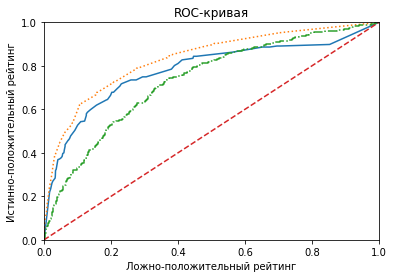

Матрица ошибок для DecisionTreeClassifier



,0,1
0,1490,214
1,92,204


Матрица ошибок для RandomForestClassifier



,0,1
0,1508,223
1,74,195


Матрица ошибок для LogisticRegression



,0,1
0,1520,323
1,62,95


,auc_roc,f1
Лес,0.823870,0.567686
Дерево,0.783743,0.571429
Лог. регрессия,0.751127,0.330435


In [11]:
probabilities_valid_tree = best_tree.predict_proba(features_valid)
probabilities_valid_forest = best_forest.predict_proba(features_valid)
probabilities_valid_lreg = best_lreg.predict_proba(features_valid)
prob_one_tree = probabilities_valid_tree[:, 1]
prob_one_forest = probabilities_valid_forest[:, 1]
prob_one_lreg = probabilities_valid_lreg[:, 1]

fpr_tree, tpr_tree, thresholds_tree = roc_curve(target_valid, prob_one_tree)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(target_valid, prob_one_forest)
fpr_lreg, tpr_lreg, thresholds_lreg = roc_curve(target_valid, prob_one_lreg)
plt.figure()

# < постройте график >
plt.plot(fpr_tree, tpr_tree, linestyle = '-')
plt.plot(fpr_forest, tpr_forest, linestyle = ':')
plt.plot(fpr_lreg, tpr_lreg, linestyle = '-.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Ложно-положительный рейтинг')
plt.ylabel('Истинно-положительный рейтинг')
plt.title('ROC-кривая')

plt.show()

models_evaluation = pd.DataFrame(columns = ['auc_roc', 'f1'], index = ['Дерево', 'Лес', 'Лог. регрессия'])
def auc_roc(model):
    probabilities_test = model.predict_proba(features_test)[:, 1]
    auc_roc = roc_auc_score(target_test, probabilities_test)
    return auc_roc
def f1(model):
    predictions_test = model.predict(features_test)
    print('Матрица ошибок для', str(model.__class__.__name__))
    print()
    display(pd.DataFrame(confusion_matrix(predictions_test, target_test)))
    f1 = f1_score(target_test, predictions_test)
    return f1
models = pd.Series([best_tree, best_forest, best_lreg], index = ['Дерево', 'Лес', 'Лог. регрессия'])
models_evaluation['auc_roc'] = models.apply(auc_roc)
models_evaluation['f1'] = models.apply(f1)
display(models_evaluation.sort_values(by = 'auc_roc', ascending = False))

### Обзор получившихся моделей
<a id='step_8'></a>
Итак, мы получили наилучшие возможные модели логистической регересии, случайного леса и решающего дерева. Проверив их на тестовой выборке, мы видим, что лучше всего справляется случайный лес: auc_roc больше всех, а f1 незначительно меньше, чем у решающего дерева. Из матриц ошибок видим, что логистическая регрессия сильно уступает своим конкурентам по показателю f1, так как она совершает на 100 и больше ошибок, предсказывая положительный класс. Однако она превосходит по предсказаниям отрицательного класса, и это хорошо! Возможно, она покажет себя лучше остальных после балансировки?

## Обучение моделей с учетом баланса классов
### Upsampling
<a id='step_9'></a>

Увеличим количество примеров с положительным классов в  3  раза


[Text(0, 0.5, 'Частота'),
 Text(0.5, 0, 'Класс'),
 Text(0.5, 1.0, 'Частоты классов')]

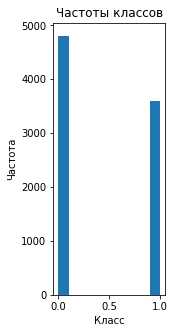

In [12]:

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
repeat = 3
print('Увеличим количество примеров с положительным классов в ', repeat, ' раза')
features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
target_upsampled.plot(kind = 'hist', figsize = (2, 5)).set(xlabel = 'Класс', ylabel = 'Частота', title = 'Частоты классов')

Методом upsampling мы добилсь того, что в данных классы сбалансированы - это хорошо видно по гистограмме. Посмотрим, как будут обучаться модели на этих данных.

In [13]:
best_f1_tree2 = 0
for depth in range(1, 50):
    tree = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    tree.fit(features_upsampled, target_upsampled)
    predictions_valid = tree.predict(features_valid)
    if f1_score(target_valid, predictions_valid) > best_f1_tree2:
        best_f1_tree2 = f1_score(target_valid, predictions_valid)
        best_depth_tree2 = depth
        best_tree2 = tree
print()
print('Лучшая модель решающего дерева имеет значение f1 = ', round(best_f1_tree2, 3), ' по валидационной выборке и значение max_depth =', best_depth_tree2)


Лучшая модель решающего дерева имеет значение f1 =  0.586  по валидационной выборке и значение max_depth = 6


In [14]:
best_f1_lreg2 = 0
for solver in solvers:
    l_reg = LogisticRegression(random_state = 12345, solver = solver, class_weight = 'balanced')
    l_reg.fit(features_upsampled, target_upsampled)
    predictions_valid = l_reg.predict(features_valid)
    print('При типе solver', solver, ' модель логистической регрессии дает f1 =', round(f1_score(target_valid, predictions_valid), 3))
    if f1_score(target_valid, predictions_valid) > best_f1_lreg2:
        best_f1_lreg2 = f1_score(target_valid, predictions_valid)
        best_solver2 = solver
        best_lreg2 = l_reg
print()
print('Лучшая модель логистической регресии наблюдается при типе solver', best_solver2, ' и дает дает f1 =', round(best_f1_lreg2, 3))

При типе solver newton-cg  модель логистической регрессии дает f1 = 0.477
При типе solver lbfgs  модель логистической регрессии дает f1 = 0.429
При типе solver liblinear  модель логистической регрессии дает f1 = 0.432
При типе solver sag  модель логистической регрессии дает f1 = 0.351
При типе solver saga  модель логистической регрессии дает f1 = 0.351

Лучшая модель логистической регресии наблюдается при типе solver newton-cg  и дает дает f1 = 0.477


In [15]:
best_f1_forest2 = 0
for depth in range(1, 25):
    for n in range(1, 25):
        forest = RandomForestClassifier(random_state = 12345, max_depth = depth, n_estimators = n)
        forest.fit(features_upsampled, target_upsampled)
        predictions_valid = forest.predict(features_valid)
        if f1_score(target_valid, predictions_valid) > best_f1_forest2:
            best_f1_forest2 = f1_score(target_valid, predictions_valid)
            best_depth_forest2 = depth
            best_n2 = n
            best_forest2 = forest
print('Лучшая модель случайного леса имеет значение f1 = ', best_f1_forest2, ' по валидационной выборке, значение max_depth =', best_depth_forest2, 'а n_estimators=', best_n2)

Лучшая модель случайного леса имеет значение f1 =  0.6235565819861433  по валидационной выборке, значение max_depth = 9 а n_estimators= 16


### Оценка полученных моделей 
<a id='step_10'></a>
Ура! Мы получили значение f1 больше 0,59 - его дал случайный лес, обученный после увеличения количества примеров с положительным классом в три раза методом upsampling с `max_depth = 10` и `n_estimators = 23`. F1 = 0.613. Сравним все полученные модели.

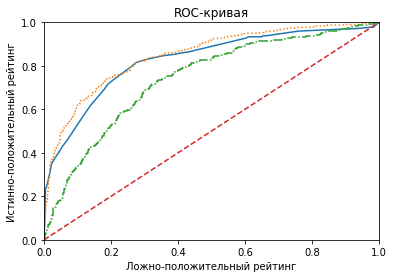

In [16]:
probabilities_valid_tree = best_tree2.predict_proba(features_valid)
probabilities_valid_forest = best_forest2.predict_proba(features_valid)
probabilities_valid_lreg = best_lreg2.predict_proba(features_valid)
prob_one_tree = probabilities_valid_tree[:, 1]
prob_one_forest = probabilities_valid_forest[:, 1]
prob_one_lreg = probabilities_valid_lreg[:, 1]

fpr_tree, tpr_tree, _ = roc_curve(target_valid, prob_one_tree)
fpr_forest, tpr_forest, _ = roc_curve(target_valid, prob_one_forest)
fpr_lreg, tpr_lreg, _ = roc_curve(target_valid, prob_one_lreg)
plt.figure()

plt.plot(fpr_tree, tpr_tree, linestyle = '-')
plt.plot(fpr_forest, tpr_forest, linestyle = ':')
plt.plot(fpr_lreg, tpr_lreg, linestyle = '-.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Ложно-положительный рейтинг')
plt.ylabel('Истинно-положительный рейтинг')
plt.title('ROC-кривая')

plt.show()


In [17]:
models_evaluation2 = pd.DataFrame(columns = ['auc_roc', 'f1'], index = ['Дерево', 'Лес', 'Лог. регрессия'])
models2 = pd.Series([best_tree2, best_forest2, best_lreg2], index = ['Дерево', 'Лес', 'Лог. регрессия'])
models_evaluation2['auc_roc'] = models2.apply(auc_roc)
models_evaluation2['f1'] = models2.apply(f1)
display(models_evaluation2.sort_values(by = 'auc_roc', ascending = False))

Матрица ошибок для DecisionTreeClassifier



,0,1
0,1299,135
1,283,283


Матрица ошибок для RandomForestClassifier



,0,1
0,1405,164
1,177,254


Матрица ошибок для LogisticRegression



,0,1
0,1119,133
1,463,285


,auc_roc,f1
Лес,0.842534,0.598351
Дерево,0.813327,0.575203
Лог. регрессия,0.763539,0.488851


### Результаты оценки моделей
<a id='step_11'></a>
Итак, мы проверили, какие результаты на тестовой выборке дают лучшие модели после балансировки классов. Видим, что логистическая регрессия не оправдала ожидания, зато случайный лес и решающее дерево показали себя одинаково хорошо. Однако лучше отдать предпочтение случайному лесу: он показал результат много лучше дерева на валидационной выборке. Рассмотрим победителя поближе.

In [18]:
best_model = best_forest2
best_model_evaluation = pd.DataFrame(columns = ['Обучающая выборка', 'Валидационная выборка', 'Тестовая выборка'], index = ['auc_roc', 'f1', 'accuracy'])
def best_auc_roc(features, target):
    probabilities = best_model.predict_proba(features)[:, 1]
    auc_roc = roc_auc_score(target, probabilities)
    return auc_roc
def best_f1(features, target):
    predictions = best_model.predict(features)
    f1 = f1_score(target, predictions)
    return f1
def accuracy(features, target):
    predictions = best_model.predict(features)
    acc = accuracy_score(target, predictions)
    return acc
def evaluation(features, target):
    auc_roc = best_auc_roc(features, target)
    f1 = best_f1(features, target)
    acc = accuracy(features, target)
    evaluation = pd.Series(index = ['auc_roc', 'f1', 'accuracy'], data = [auc_roc, f1, acc])
    return evaluation

best_model_evaluation['Обучающая выборка'] = evaluation(features_train, target_train)
best_model_evaluation['Валидационная выборка'] = evaluation(features_valid, target_valid)
best_model_evaluation['Тестовая выборка'] = evaluation(features_test, target_test)
display(best_model_evaluation.T)
predictions_test = best_model.predict(features_test)
print('Матрица ошибок на тестовой выборке')
display(pd.DataFrame(confusion_matrix(predictions_test, target_test)))

,auc_roc,f1,accuracy
Обучающая выборка,0.949743,0.753226,0.8980
Валидационная выборка,0.848711,0.623557,0.8370
Тестовая выборка,0.842534,0.598351,0.8295


Матрица ошибок на тестовой выборке


,0,1
0,1405,164
1,177,254


## Выводы
<a id='step_12'></a>
Отлично, результаты весьма неплохие. Модель справляется.
Так, мы имеем модель случайного леса, которая с примерно одинаковой, притом невысокой, частотой выдает ложно-положительные и ложно-отрицательные предсказания. В 83% случаев модель верно предсказывает класс (по тестовой выборке). Значение площади под графиком `ROC` равно 0.84, а `f1 = 0.6`. Теперь мы с большей уверенностью можем говорить, уйдет клиент или нет.